In [2]:
import math
import sys
sys.path.append('minGPT/')

import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from mingpt.bpe import BPETokenizer
from mingpt.model import GPT
from mingpt.utils import setup_logging

from config_setup import get_config
from data_handling import *
from training import *

%matplotlib inline

In [3]:
### Create the tokenizer ###

tokenizer = BPETokenizer()
tokenizer.pad_token_id = tokenizer.encoder.encoder['<|endoftext|>']

### Prepare the config ###

config = get_config([])
config.merge_from_dict({
    'model.vocab_size': len(tokenizer.encoder.encoder),
    'model.block_size': 16,
    'model.model_type': None,
    'model.n_layer': 1,
    'model.n_head': 4,
    'model.n_embd': 256,
    'model.fc_mem_dim': 128,
    'trainer.batch_size': 128,
    'trainer.epochs': 1,
    'trainer.max_samples': 200_000,
})

batch_size = config.trainer.batch_size
device = config.trainer.device

# print(config)
setup_logging(config)

if config.system.wandb:
    import wandb
    tags = [config.system.tag] if config.system.tag else None
    wandb.init(project=config.system.project, sync_tensorboard=True,
                config=config.to_dict(), tags=tags)

In [4]:
### Prepare the data ###

datasets = prepare_data(config)
dataloaders = prepare_dataloaders(datasets, tokenizer, config)

train_loader = dataloaders['train']
val_loader = dataloaders['val']
test_loader = dataloaders['test']

/home/edan/miniconda3/envs/intract/lib/python3.9/site-packages/datasets/load.py:2491: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


In [13]:
model = GPT(config.model)
model = model.to(config.trainer.device)
optimizer = model.configure_optimizers(config.trainer)
model.reset_memory(batch_size)

ltm_optimizer = torch.optim.AdamW(
    optimizer.param_groups[:2],
    lr = config.trainer.learning_rate,
    betas = config.trainer.betas,
)
stm_optimizer = torch.optim.Adam(
    optimizer.param_groups[2:],
    lr = 0.01,
    betas = config.trainer.betas,
)

del optimizer

number of parameters: 13.69M


In [14]:
# Data queue is a list of input, output sequence pairs
data_iter = iter(dataloaders['train'])
curr_sequences = next(data_iter)
model.reset_memory(len(curr_sequences['input_ids']))


epoch = 0
bar = tqdm(
    total = len(train_loader) * config.trainer.batch_size * config.trainer.epochs,
    desc = f'Loss: {0:.4f}',
    position = 0,
)

losses = []
while epoch < config.trainer.epochs:
    # If the current sequence is empty, get the next batch of sequences
    if curr_sequences['input_ids'].shape[1] == 0:
        try:
            curr_sequences = next(data_iter)
            if curr_sequences['input_ids'].shape[0] != config.trainer.batch_size:
                raise StopIteration
            # print('-- reset memories --')
            model.reset_memory(len(curr_sequences['input_ids']))
            # sample_iter += curr_sequences['input_ids'].shape[0]
            bar.update(curr_sequences['input_ids'].shape[0])
        except StopIteration:
            data_iter = iter(dataloaders['train'])
            epoch += 1
            continue

    
    # Create a training batch from a portion of the current sequences
    batch = {k: v[:, :config.model.block_size].to(config.trainer.device) for k, v in curr_sequences.items()}
    curr_sequences = {k: v[:, config.model.block_size:] for k, v in curr_sequences.items()}

    input_ids = batch['input_ids'].to(config.trainer.device)
    labels = batch['labels'].to(config.trainer.device)

    # Learn to work with the memory
    _, loss = model(input_ids, labels)

    ltm_optimizer.zero_grad()
    loss.backward()
    ltm_optimizer.step()

    losses.append(loss.item())
    bar.set_description(f"Loss: {loss.item():.4f}")

    # # Memorize the current sequence
    # for _ in range(10):
    #     _, loss = model(input_ids, labels)

    #     stm_optimizer.zero_grad()
    #     loss.backward()
    #     stm_optimizer.step()

Loss: 1.2979: 100%|█████████▉| 177792/178048 [02:49<00:00, 980.18it/s] 

In [16]:
# no_mem_losses = losses
# mem_losses = losses
# double_mem_losses = losses

In [17]:
def bucket_mean(data, n):
    bucket_size = math.ceil(len(data) / n)
    return [sum(data[i:i+bucket_size]) / len(data[i:i+bucket_size]) for i in range(0, len(data), bucket_size)]

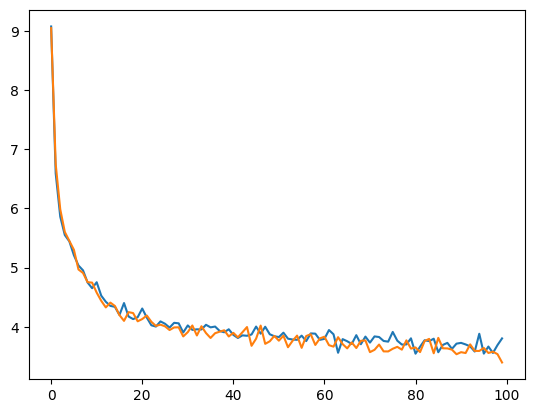

In [18]:
plt.plot(bucket_mean(no_mem_losses, 100))
plt.plot(bucket_mean(mem_losses, 100))